<a href="https://colab.research.google.com/github/smahesh2694/MVTec_GradCAM/blob/master/MVTec_ResNet101V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification on recasted MVTec dataset as a supervised problem using ResNet101 architecture

# Dependencies

In [ ]:
# check GPU compatibility

import tensorflow as tf
%tensorflow_version 1.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# mount drive to access the dataset through colab

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# go to the dataset directory

%cd /content/drive/My Drive/data

In [ ]:
#import necessary packages

import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt

from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.applications import ResNet101V2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

Using TensorFlow backend.


# Load keras model

ResNet101 architecture updated in 2016 by author as **ResNet101V2** is utilized. The accuracy was found to be increased by updating the residual modules to use [identity mappings](https://arxiv.org/abs/1603.05027).

In [ ]:
img_height = 224
img_width = 224

base_model = ResNet101V2(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

num_classes = 30

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x=Dense(512, activation='relu')(x) 
preds = Dense(num_classes, activation= 'softmax')(x)

model = Model(inputs = base_model.input, outputs = preds)

In [ ]:
v = 0
a = model.layers
print("Total layers in ResNet101V2 : ", len(a))
for i in range(len(a)):
            if type(a[i]) == keras.layers.convolutional.Conv2D:
                v += 1
                # print(a[i])
print("No. of Conv2D layers : ", v)

Total layers in ResNet101V2 :  381
No. of Conv2D layers :  104


In [ ]:
# set the base model to be not trainable

base_model.trainable = False

In [ ]:
# validation split - 20 %

train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 validation_split=0.2)

In [ ]:
bs = 16                   #change batch size accordingly

CLASSES = ['defective_bottle','defective_cable','defective_capsule','defective_carpet',
           'defective_grid','defective_hazelnut','defective_leather','defective_metalnut',
           'defective_pill','defective_screw','defective_tile','defective_toothbrush',
           'defective_transistor','defective_wood','defective_zipper','good_bottle',
           'good_cable','good_capsule','good_carpet','good_grid',
           'good_hazelnut','good_leather','good_metalnut','good_pill',
           'good_screw','good_tile','good_toothbrush','good_transistor',
           'good_wood','good_zipper']

In [ ]:
train_generator=train_datagen.flow_from_directory('train',  
                                                 target_size=(224,224),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training',
                                                 classes=CLASSES)

Found 2923 images belonging to 30 classes.


In [ ]:
label_map = (train_generator.class_indices)
print("Label map: ",label_map)

val_generator=train_datagen.flow_from_directory('train', 
                                                 target_size=(224,224),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 714 images belonging to 30 classes.


In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
print("Training step size: ",step_size_train)

step_size_val = (val_generator.n//val_generator.batch_size) + 1
print("Validation step size: ",step_size_val)

Training step size:  182
Validation step size:  45


In [ ]:
# SGD optimizer is used

from keras.callbacks import LearningRateScheduler

sgd = SGD()

model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['acc'])

# Training

In [ ]:
initial_epochs = 25        #change as per requirement

import math

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  drop_every = 5.0        #change as per requirement
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/drop_every))
  return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs,
                   callbacks = callbacks_list)

Epoch 1/25
182/182 [==============================] - 1521s 8s/step - loss: 0.7276 - acc: 0.7154 - val_loss: 0.8208 - val_acc: 0.7633
Epoch 2/25
182/182 [==============================] - 226s 1s/step - loss: 0.6037 - acc: 0.7585 - val_loss: 0.5878 - val_acc: 0.7059
Epoch 3/25
182/182 [==============================] - 226s 1s/step - loss: 0.5987 - acc: 0.7555 - val_loss: 0.6493 - val_acc: 0.7619
Epoch 4/25
182/182 [==============================] - 224s 1s/step - loss: 0.5231 - acc: 0.7896 - val_loss: 0.4731 - val_acc: 0.8095
Epoch 5/25
182/182 [==============================] - 224s 1s/step - loss: 0.4375 - acc: 0.8280 - val_loss: 0.4432 - val_acc: 0.8487
Epoch 6/25
182/182 [==============================] - 222s 1s/step - loss: 0.3920 - acc: 0.8487 - val_loss: 0.4665 - val_acc: 0.7969
Epoch 7/25
182/182 [==============================] - 219s 1s/step - loss: 0.3605 - acc: 0.8582 - val_loss: 0.3822 - val_acc: 0.8739
Epoch 8/25
182/182 [==============================] - 219s 1s/step -

In [ ]:
# plot the learning rate curve over epochs

x_axis = list(range(1,initial_epochs+1))
y_axis = loss_history.lr
plt.plot(x_axis, y_axis)
plt.grid(None)
plt.title('Learnig rate vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.grid(None)

# Evaluating trained model

In [ ]:
# evaluating the model

scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

45/45 [==============================] - 40s 890ms/step
Validating loss: 0.2809204690429677
Validating accuracy: 0.9103641458252231


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

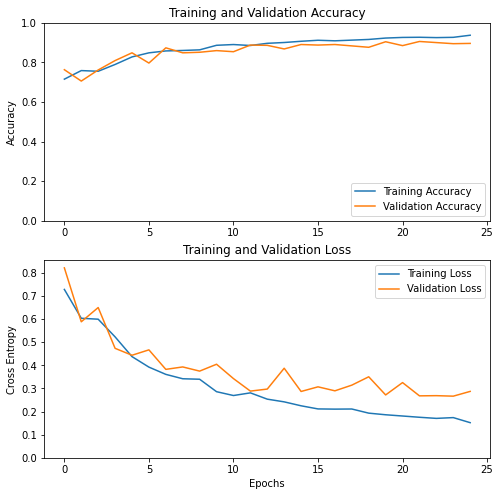

In [ ]:
# plot the training and validation process' accuracy and loss

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Fine Tune

In [ ]:
"""
  Reset the base_model to be trainable and start fine tuning the final 2/3rd of layers.
"""

base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 2 * (len(base_model.layers)) / 3

for layer in base_model.layers[:int(fine_tune_at)]:
  layer.trainable =  False

print(int(fine_tune_at))

Number of layers in the base model:  377
251


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs,
                   callbacks = callbacks_list)

Epoch 26/35


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


182/182 [==============================] - 227s 1s/step - loss: 0.1600 - acc: 0.9336 - val_loss: 0.2961 - val_acc: 0.8950
Epoch 27/35
182/182 [==============================] - 224s 1s/step - loss: 0.1567 - acc: 0.9363 - val_loss: 0.2613 - val_acc: 0.8992
Epoch 28/35
182/182 [==============================] - 225s 1s/step - loss: 0.1528 - acc: 0.9356 - val_loss: 0.2717 - val_acc: 0.9020
Epoch 29/35
182/182 [==============================] - 226s 1s/step - loss: 0.1537 - acc: 0.9392 - val_loss: 0.2744 - val_acc: 0.9146
Epoch 30/35
182/182 [==============================] - 225s 1s/step - loss: 0.1481 - acc: 0.9383 - val_loss: 0.2730 - val_acc: 0.9006
Epoch 31/35
182/182 [==============================] - 227s 1s/step - loss: 0.1449 - acc: 0.9396 - val_loss: 0.2681 - val_acc: 0.9104
Epoch 32/35
182/182 [==============================] - 224s 1s/step - loss: 0.1416 - acc: 0.9428 - val_loss: 0.2614 - val_acc: 0.8992
Epoch 33/35
182/182 [==============================] - 223s 1s/step - loss

In [ ]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

45/45 [==============================] - 41s 910ms/step
Validating loss: 0.2634405433213344
Validating accuracy: 0.9019607843137255


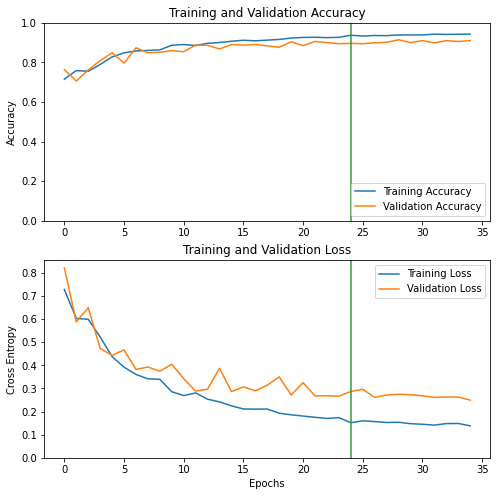

In [ ]:
# plot the training and validation process' accuracy and loss

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.grid(None)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.grid(None)
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(None)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.ylim([0,max(plt.ylim())])
plt.grid(None)
plt.title('Training and Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.show()

# Test

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [ ]:
bs_test = 8           #change test batch size here

test_generator = test_datagen.flow_from_directory('test',
                                                  target_size=(224,224),     
                                                  batch_size=bs_test,
                                                  class_mode='categorical',
                                                  shuffle = False)

Found 1542 images belonging to 30 classes.


In [ ]:
step_size_test = (test_generator.n//test_generator.batch_size)+1
print("Test step size : ", step_size_test)
test_generator.reset()

Test step size :  193


In [ ]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

193/193 [==============================] - 1352s 7s/step


In [ ]:
acc_o = np.sum(np.argmax(predIndxs, axis=1).astype('int') == test_generator.labels) / test_generator.n
print("Test Accuracy : ",acc_o)

Test Accuracy :  0.9124513618677043


In [ ]:
# ROC curve 

auc = []
fpr_def = []
tpr_def = []

for iter_class, c in enumerate(CLASSES[:8]):    # slice the corresponding class numbers
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

In [ ]:
predIndxs_max = np.argmax(predIndxs, axis=1)
print(classification_report(test_generator.classes, predIndxs_max, target_names=test_generator.class_indices.keys()))

                      precision    recall  f1-score   support

    defective_bottle       1.00      0.89      0.94        19
     defective_cable       0.82      0.82      0.82        28
   defective_capsule       0.57      0.12      0.20        33
    defective_carpet       1.00      0.89      0.94        27
      defective_grid       1.00      0.50      0.67        14
  defective_hazelnut       1.00      0.95      0.98        21
   defective_leather       1.00      1.00      1.00        28
  defective_metalnut       1.00      0.61      0.76        28
      defective_pill       0.73      0.38      0.50        42
     defective_screw       1.00      0.06      0.11        17
      defective_tile       1.00      0.92      0.96        25
defective_toothbrush       1.00      0.56      0.71         9
defective_transistor       1.00      0.50      0.67        12
      defective_wood       1.00      0.83      0.91        18
    defective_zipper       0.97      0.86      0.91        36
       

In [ ]:
print('Confusion matrix:')
cm = confusion_matrix(test_generator.classes,predIndxs_max)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5] + cm[6, 6] +
       cm[7, 7] + cm[8, 8] + cm[9, 9] + cm[10, 10] + cm[11, 11] + cm[12, 12] +
       cm[13, 13] + cm[14, 14] + cm[15, 15] + cm[16, 16] + cm[17, 17] + cm[18, 18] +
       cm[19, 19] + cm[20, 20] + cm[21, 21] + cm[22, 22] + cm[23, 23] + cm[24, 24] +
       cm[25, 25] + cm[26, 26] + cm[27, 27] + cm[28, 28] + cm[29, 29]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

Confusion matrix:
[[ 17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0  29
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  24   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    3   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   7   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  28   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  11   0   0   0

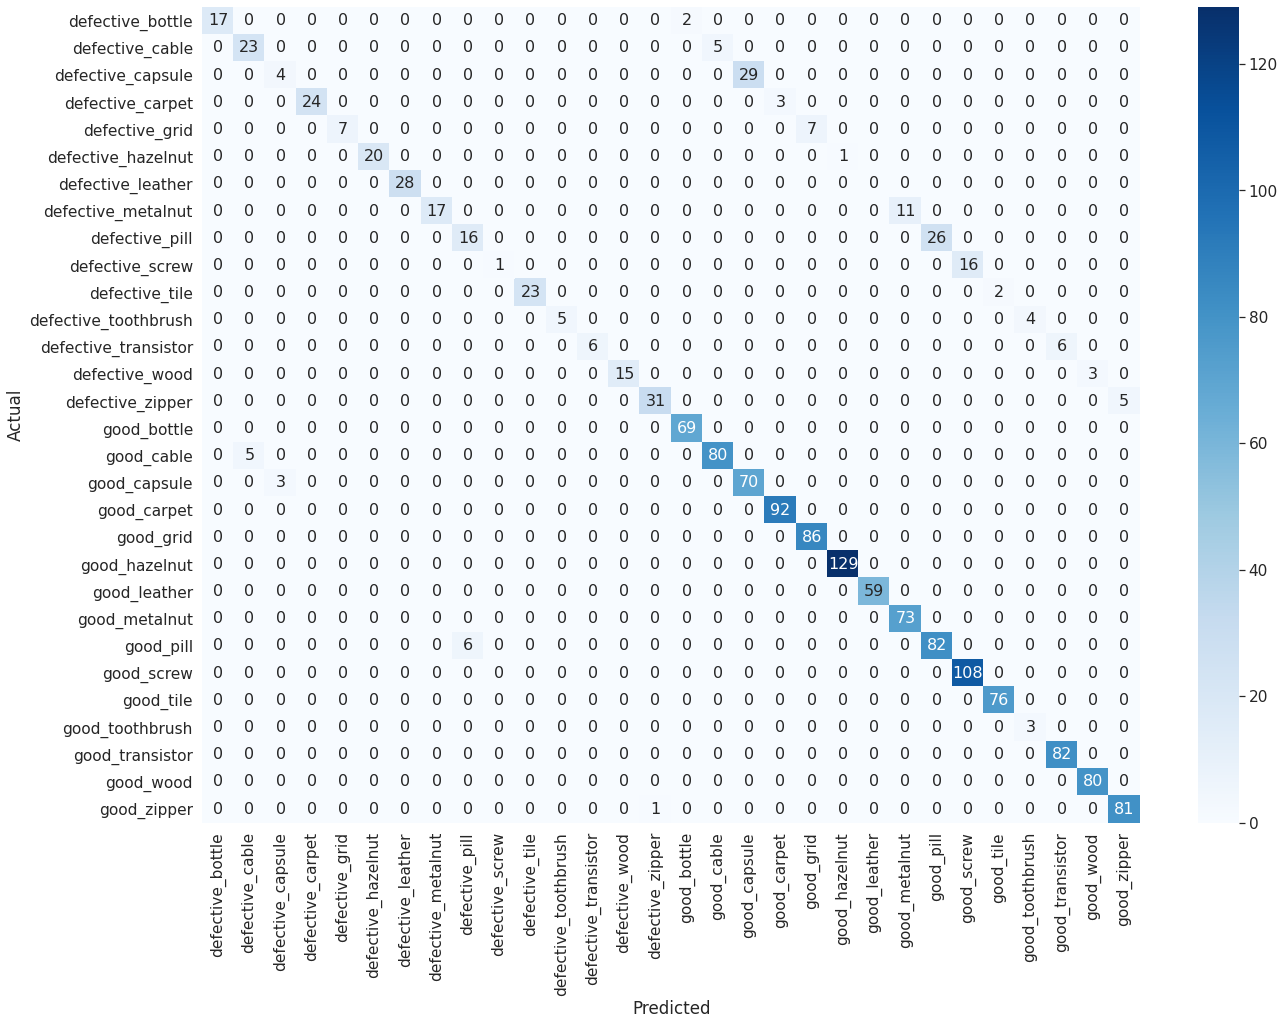

In [ ]:
import seaborn as sn
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")

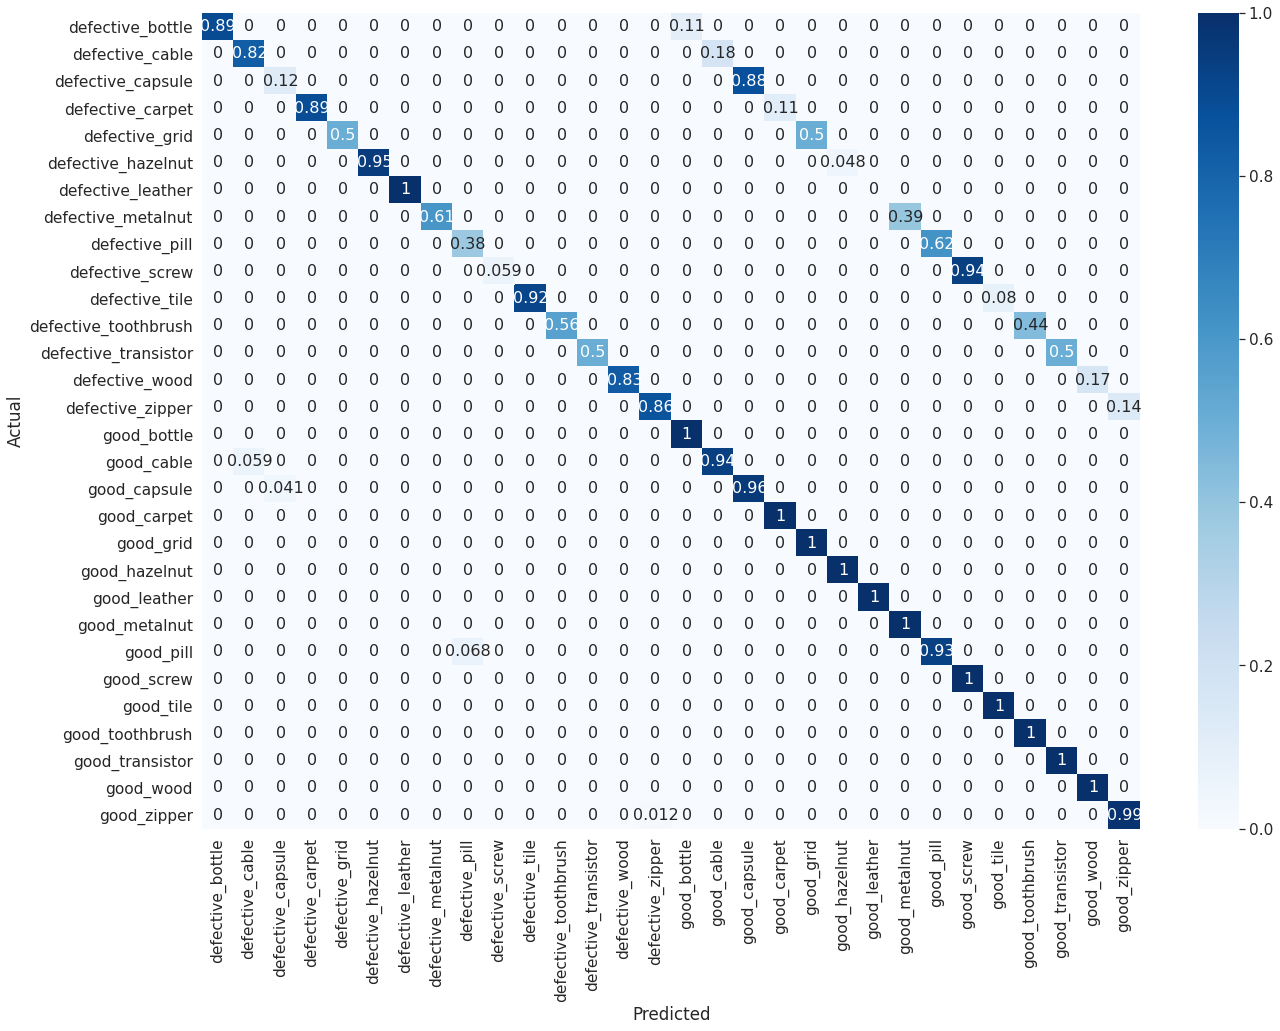

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt_cm = pd.DataFrame(cm_normalized, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Prediction

In [ ]:
# path to the corresponding test image

image_path = "/content/drive/My Drive/data/test/defective_screw/screw_scratch_head_001.png"

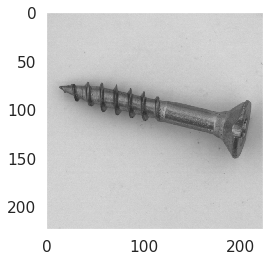

In [ ]:
test_img = image.load_img(image_path, target_size=(224,224,3))
plt.grid(None)
plt.imshow(test_img)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [ ]:
label_map_inv = {v:k  for k,v in label_map.items()}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

[[1.39407584e-05 1.13763472e-05 8.45212417e-05 1.77396250e-05
  2.98587347e-05 2.42182000e-06 1.04242617e-05 3.90353989e-06
  1.17008021e-05 3.28709036e-01 4.49600557e-05 1.45037975e-05
  1.84614255e-05 2.56943167e-05 8.01468559e-06 1.11925410e-05
  6.03065782e-05 3.25740039e-05 7.41646681e-06 4.10077482e-05
  3.11905478e-06 3.70895327e-06 7.73664942e-06 5.77594437e-06
  6.70753777e-01 2.41698272e-05 1.17514492e-05 1.08082304e-05
  1.13001806e-05 8.74536181e-06]]
[24]
Output :  good_screw
